# P1. Classification Animals-10

Task: load the Animals-10, write a simple neural network to perform classification over most frequent face classes, test the network and plot the results for each class.

<!-- ![Animals-10](https://storage.googleapis.com/kaggle-datasets-images/59760/115796/95649e825d9344084af2a24012c4d072/dataset-cover.jpg?t=2018-10-05-08-07-40) -->

## Task 0: Import libraries ✅

All the libraries in this section should be enough for the project. If you want to, you can import more libraries.

In [1]:
# We need to first install PyTorch Lightning, since it's not included in Python
%pip install pytorch-lightning torchvision


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Matplotlib for plotting, numpy for math operations
from matplotlib import pyplot as plt
import numpy as np

# PyTorch Lightning ⚡ to define our neural network
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.tuner import Tuner

# Dataloader and torchvision to define our input dataset
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Torchmetrics to monitor metrics (classification accuracy)
from torchmetrics.functional.classification.accuracy import accuracy

## Task 1: Download/Import Dataset 📃
Link full dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

Link tiny version: https://drive.google.com/file/d/1mJWlU-jHWYZPonFHF5Kmdhhb6OfJmnD5/view?usp=sharing

In [3]:
import os
# Make sure to upload the data in colab
# Importing our dataset

## Task 1: Define parameters and hyperparameters 📃


*   **Learning rate** - how fast does our network learn? (Warning, do not set too high)
*   **Batch size** - how many samples does the network "see" at every iteration (usually, the bigger the better)
*   **Dataset size** - how many samples are in the whole dataset? (train + validation)
*   **Train size** - how many samples are in the training dataset?
*   **Val size** - how many samples are in the validation dataset?
*   **Input width** - how wide (in pixels) is our input image? (must be square images)
*   **Input height** - how tall (in pixels) is our input image? (must be square images)
*   **Input channels** - how many channels does the input image have?
*   **Mean** - dataset mean
*   **Std** - dataset standard variance
*   **Hidden dim** - how many neurons are there in the hidden layer?
*   **Num classes** - how many classes (digits) do we want to classify in our dataset?





In [4]:
input_width = 128
input_height = 128
input_channels = 3

train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [5]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)
if torch.backends.cudnn.enabled:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [6]:
# Load the dataset

batch_size = 64

# Manual Transform the dataset to crop the images to the same size
manual_transform = transforms.Compose([
  transforms.Resize((input_width, input_height)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5126, 0.4952, 0.4027], std=[0.2649, 0.2580, 0.2753]),
])

dataset = ImageFolder(root='animals10/raw-img', transform=manual_transform) #set correct path
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [7]:
learning_rate = 0.0001

dataset_size = len(dataset)

# Compute mean and standard deviation for each channel
# mean = torch.zeros(3)
# std = torch.zeros(3)

# for images, _ in loader:
#   for i in range(input_channels):
#     mean[i] += images[:, i, :, :].mean()
#     std[i] += images[:, i, :, :].std()

# mean /= len(loader)
# std /= len(loader)

# print(f'Mean: {mean}')
# print(f'Std: {std}')

hidden_dim = 512
num_classes = 10

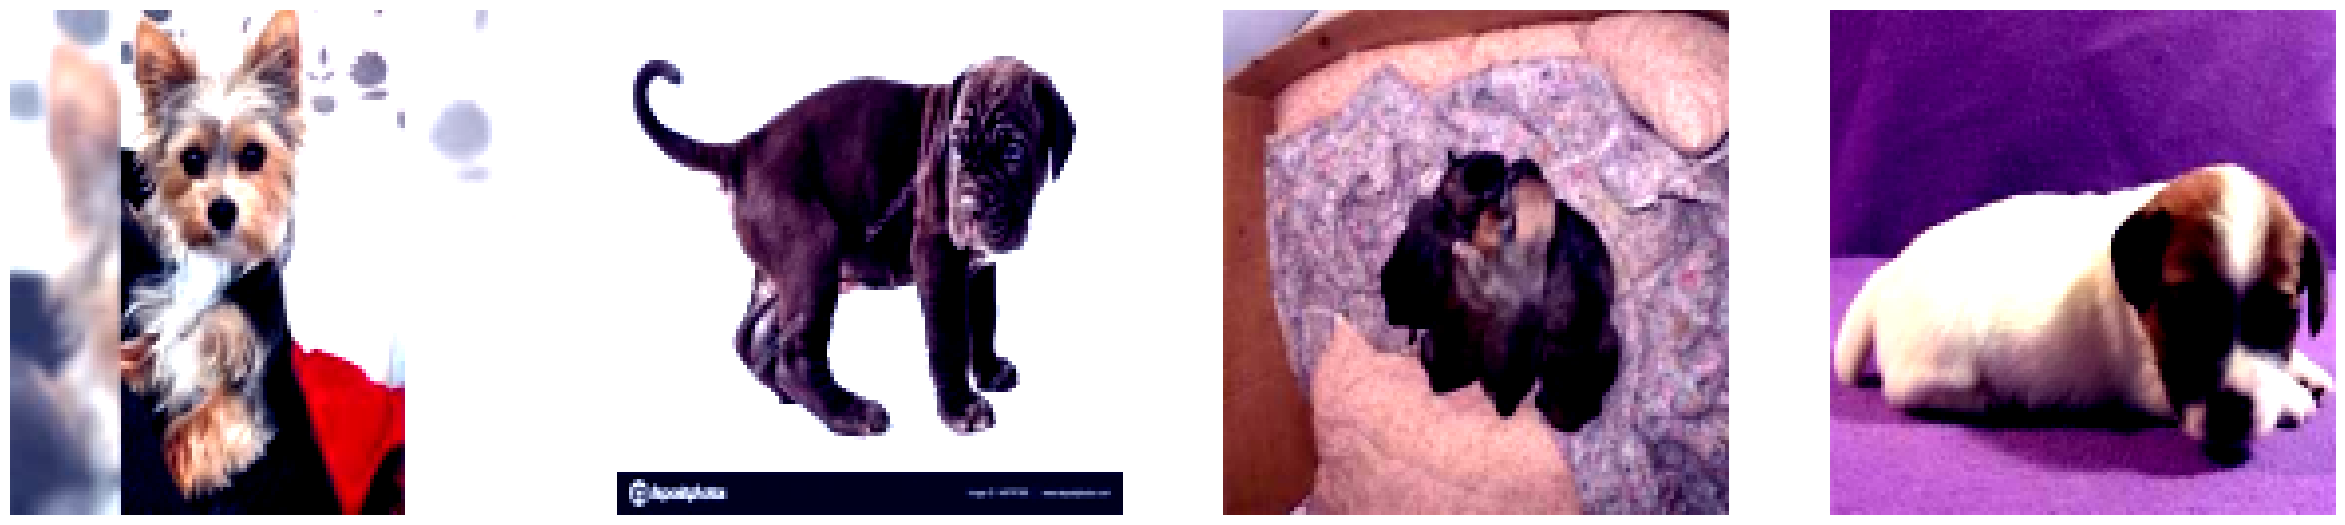

In [8]:
# Get some random training images
dataiter = iter(loader)
images, labels = next(dataiter)
# Use a subset of the images to speed up plotting
images = images[:4]

# Plot the images in a single plot
fig, axes = plt.subplots(1, len(images), figsize=(30, 30))
for idx, img in enumerate(images):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  axes[idx].imshow((np.transpose(npimg, (1, 2, 0))).clip(0, 1))
  axes[idx].axis('off')
plt.show()

## Task 2: Define the DataModule 📃
Download the LFW dataset filter the most frequent classes and prepare the train/val/test splits

🌟 **HINT** 🌟
Filtering of the data can be done in the setup function of the Datamodule

In [ ]:
class MyCustomDataModule(pl.LightningDataModule):
  def __init__(self, data_dir: str = "./"):
    super().__init__()

  def prepare_data(self):
    self.dataset = dataset

  def setup(self, stage = None):
    # Split the dataset
    train_size = int(train_percentage * dataset_size)
    val_size = int(val_percentage * dataset_size)
    test_size = dataset_size - train_size - val_size

    self.dataset_train, self.dataset_val, self.dataset_test = random_split(self.dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

    # targets = np.array([s[1] for s in self.dataset.samples])
    # train_indices, val_indices, test_indices = [], [], []

    # for class_idx in range(num_classes):
    #   class_indices = np.where(targets == class_idx)[0]
    #   np.random.shuffle(class_indices)
    #   train_end = int(train_percentage * len(class_indices))
    #   val_end = int(val_percentage * len(class_indices)) + train_end

    #   train_indices.extend(class_indices[:train_end])
    #   val_indices.extend(class_indices[train_end:val_end])
    #   test_indices.extend(class_indices[val_end:])

    # if stage == "fit" or stage is None:
    #   self.dataset_train = torch.utils.data.Subset(self.dataset, train_indices)
    #   self.dataset_val = torch.utils.data.Subset(self.dataset, val_indices)
    # if stage == "test" or stage is None:
    #   self.dataset_test = torch.utils.data.Subset(self.dataset, test_indices)

  def train_dataloader(self):
      return DataLoader(self.dataset_train, batch_size=batch_size)

  def val_dataloader(self):
      return DataLoader(self.dataset_val, batch_size=batch_size)

  def test_dataloader(self):
      return DataLoader(self.dataset_test, batch_size=batch_size)

## Task 3: Define the neural network 📃


In [10]:
class MyCustomModel(LightningModule):
  def __init__(self):
    super().__init__()

    self.ground_truth = []
    self.predictions = []
    self.lr = learning_rate

    self.fc1 = nn.Linear(128*128*3, 980)
    self.fc2 = nn.Linear(980, 123)
    self.fc3 = nn.Linear(123, 10)
    
    self.dropout = nn.Dropout(p= 0.25)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

  def training_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass',num_classes=len(target))

    self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("train_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def validation_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("val_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def test_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.ground_truth.append(target.data)     # Save ground truth
    self.predictions.append(preds.data)       # Save predictions

    self.log("test_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("test_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

## Task 4: Train 📃

In [11]:
# Init our model
model = MyCustomModel()

# Init DataModule
datamodule = MyCustomDataModule()

# Initialize a trainer
trainer = Trainer(
  max_epochs=10
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
import gc
%set_env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

# Train the model
trainer.fit(model, datamodule)
gc.collect()


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | fc1     | Linear  | 48.2 M | train
1 | fc2     | Linear  | 120 K  | train
2 | fc3     | Linear  | 1.2 K  | train
3 | dropout | Dropout | 0      | train
--------------------------------------------
48.3 M    Trainable params
0         Non-trainable params
48.3 M    Total params
193.167   Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 287/287 [01:05<00:00,  4.41it/s, v_num=188, val_loss=1.720, val_acc=0.425, train_loss=1.280, train_acc=0.560]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 287/287 [01:06<00:00,  4.33it/s, v_num=188, val_loss=1.720, val_acc=0.425, train_loss=1.280, train_acc=0.560]


225

Latest version: 188


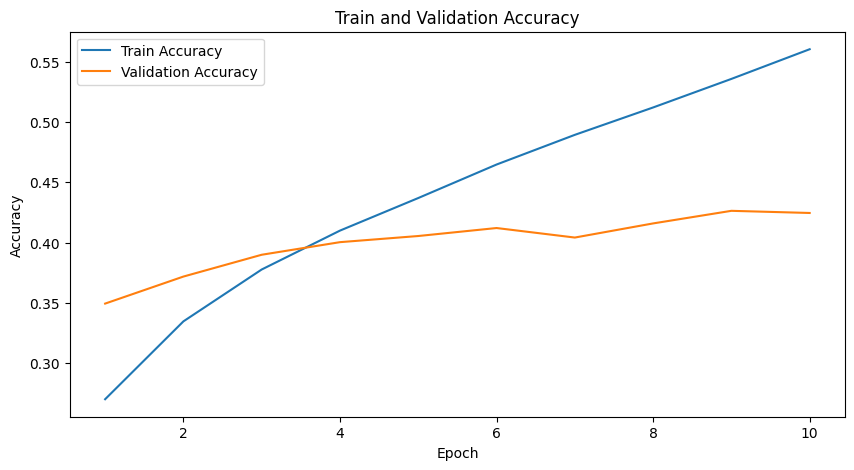

In [13]:
import pandas as pd

# Load the logs
# Load the latest version of the logs
log_dir = 'lightning_logs'
latest_version = max([int(d.split('_')[-1]) for d in os.listdir(log_dir) if d.startswith('version_')])
metrics = pd.read_csv(f'{log_dir}/version_{latest_version}/metrics.csv')

print(f'Latest version: {latest_version}')

# Extract the relevant data
train_acc = metrics['train_acc'].dropna().values
val_acc = metrics['val_acc'].dropna().values
epochs = range(1, len(train_acc) + 1)

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

## Task 5: Test ✅

In [14]:
trainer.test(model, datamodule=datamodule)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 62/62 [00:11<00:00,  5.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4228615164756775
        test_loss            1.73622727394104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.73622727394104, 'test_acc': 0.4228615164756775}]

## Task 6: Show results and experiment with splits 📃

In [15]:
print("Ground truth length: ", len(model.ground_truth))
print("Predictions length: ", len(model.predictions))

print("Ground truth sample: ", model.ground_truth)
print("Predictions sample: ", model.predictions)

Ground truth length:  62
Predictions length:  62
Ground truth sample:  [tensor([4, 9, 8, 8, 8, 3, 8, 7, 4, 5, 0, 5, 9, 1, 0, 0, 5, 2, 0, 0, 7, 2, 4, 1,
        5, 0, 8, 8, 0, 3, 4, 0, 0, 7, 8, 8, 6, 8, 4, 0, 9, 7, 8, 5, 8, 6, 0, 8,
        3, 8, 3, 2, 4, 2, 7, 6, 1, 8, 2, 1, 8, 2, 1, 8], device='mps:0'), tensor([6, 5, 7, 0, 5, 4, 1, 7, 4, 8, 0, 4, 9, 7, 3, 8, 3, 4, 4, 4, 1, 9, 4, 3,
        6, 0, 0, 1, 2, 4, 0, 7, 4, 4, 6, 0, 8, 3, 4, 8, 7, 4, 6, 1, 1, 3, 9, 8,
        1, 0, 4, 7, 0, 0, 0, 8, 4, 9, 0, 1, 3, 4, 4, 1], device='mps:0'), tensor([3, 0, 1, 3, 1, 8, 0, 5, 0, 9, 1, 0, 4, 9, 1, 9, 5, 4, 3, 0, 0, 7, 4, 0,
        6, 7, 4, 7, 3, 9, 6, 3, 8, 6, 4, 0, 7, 3, 9, 3, 1, 5, 5, 9, 8, 5, 4, 3,
        4, 8, 9, 6, 0, 9, 9, 8, 3, 0, 5, 4, 8, 6, 4, 9], device='mps:0'), tensor([4, 0, 0, 4, 8, 7, 1, 8, 0, 8, 3, 7, 4, 0, 7, 0, 8, 9, 5, 0, 9, 0, 0, 8,
        2, 9, 3, 7, 0, 4, 8, 5, 4, 1, 6, 8, 0, 9, 2, 0, 9, 0, 0, 0, 0, 3, 7, 7,
        0, 4, 5, 5, 0, 9, 8, 4, 0, 3, 7, 0, 1, 3, 0, 8], device='m

In [16]:
correct = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, (batch_gt, batch_pred) in enumerate(zip(model.ground_truth, model.predictions)):
  for gt, pred in zip(batch_gt, batch_pred):
    if gt == pred:
      correct[gt] += 1
    else:
      wrong[gt] += 1

print(correct)
print(wrong)

[324, 197, 51, 130, 193, 25, 91, 101, 490, 59]
[412, 212, 167, 202, 258, 225, 186, 168, 217, 220]


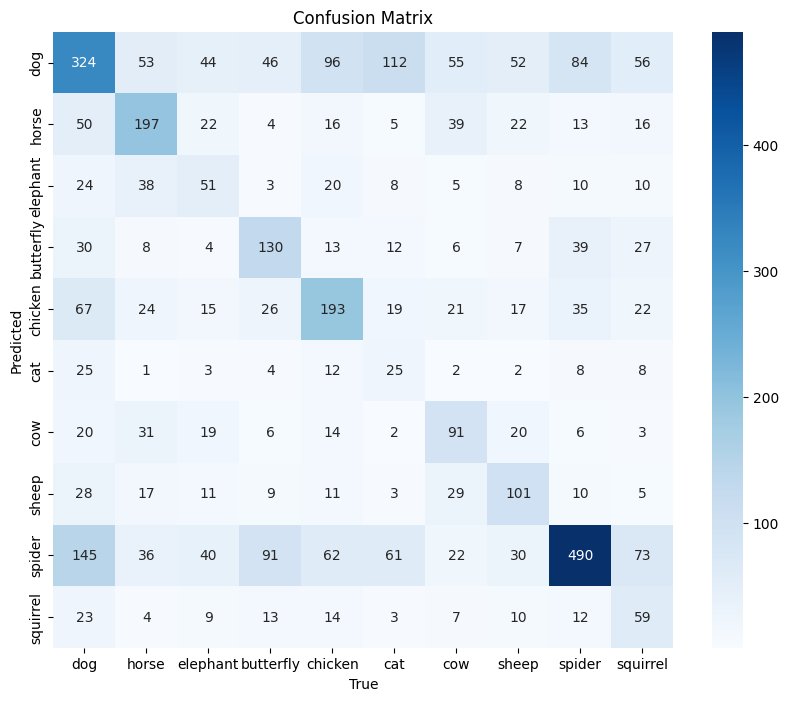

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming class_labels contains the animal names
animal_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Flatten the ground truth and predictions
ground_truth_flat = torch.cat(model.ground_truth).cpu().numpy()
predictions_flat = torch.cat(model.predictions).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(predictions_flat, ground_truth_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Validate model

In [18]:
# Validate the model
trainer.validate(model, datamodule=datamodule)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 62/62 [00:09<00:00,  6.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.42460519075393677
        val_loss            1.7243525981903076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.7243525981903076, 'val_acc': 0.42460519075393677}]

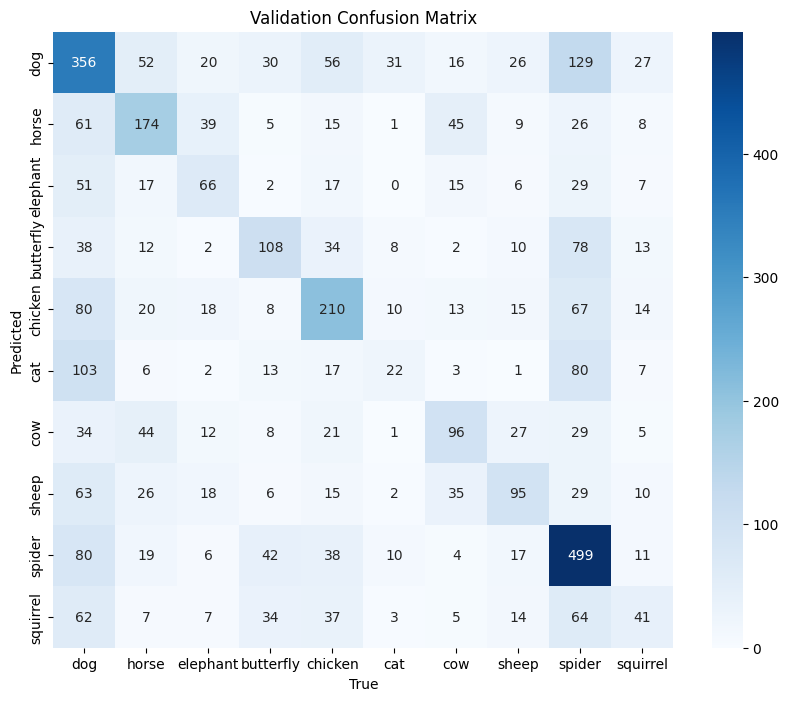

In [19]:
# Get validation data
val_loader = datamodule.val_dataloader()
ground_truth_val = []
predictions_val = []

# Collect predictions and ground truth
model.eval()
with torch.no_grad():
  for batch in val_loader:
    images, labels = batch
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    ground_truth_val.append(labels)
    predictions_val.append(preds)

# Flatten the ground truth and predictions
ground_truth_val_flat = torch.cat(ground_truth_val).cpu().numpy()
predictions_val_flat = torch.cat(predictions_val).cpu().numpy()

# Compute the confusion matrix
cm_val = confusion_matrix(ground_truth_val_flat, predictions_val_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()